In [36]:
pip install gymnasium 

Note: you may need to restart the kernel to use updated packages.


In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as distributions

import matplotlib.pyplot as plt
import numpy as np
import gymnasium as gym

In [38]:
env = gym.make('CartPole-v1')

In [39]:
# Neural Net
class NN(nn.Module):
    
    def __init__(self, n_observations, n_actions):
        super(NN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)  # Input layer
        self.layer2 = nn.Linear(128, 128)  # Hidden layer
        self.layer3 = nn.Linear(128, n_actions)  # Output layer

    def forward(self, x):
        x = F.relu(self.layer1(x))  # Activation function for the first layer
        x = F.relu(self.layer2(x))  # Activation function for the second layer
        x = F.dropout(x, p=0.5)  # Dropout regularization
        x = self.layer3(x)  # Output layer
        return x

In [40]:
# Actor Critic class
class AC(nn.Module):
    def __init__(self, actor, critic):
        super().__init__()
        
        self.actor = actor
        self.critic = critic
        
    def forward(self, state):
        action_prob_pred = self.actor(state)
        state_value_pred = self.critic(state)
        
        # returns the action and value
        return action_prob_pred, state_value_pred

In [41]:
# compute the Expected G-value returns
def compute_returns(rewards, discount_factor):
    
    returns = []
    G = 0
    
    for g in reversed(rewards):
        G = g + G * discount_factor # Discounted return calculation
        returns.insert(0, G)
        
    returns = torch.tensor(returns)
    
        
    return returns

In [42]:
# Calculate the policy loss and value loss
def optimize(returns, log_prob_actions, values, optimizer):
    
    policy_loss = - (returns * log_prob_actions).sum()  # Policy loss calculation
    value_loss = F.smooth_l1_loss(returns, values).sum()  # Value loss calculation
    
    optimizer.zero_grad()
    
    policy_loss.backward()  # Backpropagation for policy loss
    value_loss.backward()  # Backpropagation for value loss
    
    optimizer.step()


In [46]:
#input output shapes for NN
n_observations = env.observation_space.shape[0]
n_actions = env.action_space.n

#declare actor and critic NN
actor = NN(n_observations, n_actions)
critic = NN(n_observations, 1)
# create AC as policy net
policy_net = AC(actor, critic)
#load weights
policy_net.load_state_dict(policy_net.state_dict())

#Adam optimizer
optimizer = optim.Adam(policy_net.parameters(), lr=0.001)

#constants
gamma = 0.99  # Discount factor
num_episodes = 500
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

episodes = []
train_rewards = []

for episode in range(1, num_episodes+1):
    log_prob_actions = []
    values = []
    rewards = []
    done = False
    episode_reward = 0

    state, _ = env.reset()

    for i in range(1000):
        state = torch.FloatTensor(state).unsqueeze(0).to(device)

        action_prob_pred, state_value_pred = policy_net(state)

        action_prob = F.softmax(action_prob_pred, dim=-1)

        dist = distributions.Categorical(action_prob)  # Categorical distribution over actions

        action = dist.sample()  # Sample an action from the distribution

        log_prob_action = dist.log_prob(action)  # Log probability of the sampled action

        state, reward, terminated, truncated, _ = env.step(action.item())  # Take the action in the environment
        done = terminated or truncated
        
        log_prob_actions.append(log_prob_action)
        rewards.append(reward)
        values.append(state_value_pred)

        episode_reward += reward
        if done:
            break

    log_prob_actions = torch.cat(log_prob_actions)
    values = torch.cat(values).squeeze(-1)
    
    returns = compute_returns(rewards, gamma)  # Compute the returns

    optimize(returns, log_prob_actions, values, optimizer)  # Update the policy network

    train_reward = episode_reward
    
    episodes.append(episode)
    train_rewards.append(train_reward)
    
#     print('episode: ', episode)
#     print('train reward: ', train_reward)
#     print()

episode:  1
train reward:  32.0

episode:  2
train reward:  35.0

episode:  3
train reward:  22.0

episode:  4
train reward:  22.0

episode:  5
train reward:  27.0

episode:  6
train reward:  15.0

episode:  7
train reward:  24.0

episode:  8
train reward:  14.0

episode:  9
train reward:  25.0

episode:  10
train reward:  21.0

episode:  11
train reward:  50.0

episode:  12
train reward:  16.0

episode:  13
train reward:  19.0

episode:  14
train reward:  36.0

episode:  15
train reward:  30.0

episode:  16
train reward:  48.0

episode:  17
train reward:  12.0

episode:  18
train reward:  51.0

episode:  19
train reward:  16.0

episode:  20
train reward:  42.0

episode:  21
train reward:  30.0

episode:  22
train reward:  17.0

episode:  23
train reward:  32.0

episode:  24
train reward:  23.0

episode:  25
train reward:  30.0

episode:  26
train reward:  34.0

episode:  27
train reward:  14.0

episode:  28
train reward:  39.0

episode:  29
train reward:  35.0

episode:  30
train rewa

episode:  238
train reward:  107.0

episode:  239
train reward:  142.0

episode:  240
train reward:  148.0

episode:  241
train reward:  136.0

episode:  242
train reward:  150.0

episode:  243
train reward:  271.0

episode:  244
train reward:  192.0

episode:  245
train reward:  115.0

episode:  246
train reward:  217.0

episode:  247
train reward:  271.0

episode:  248
train reward:  138.0

episode:  249
train reward:  201.0

episode:  250
train reward:  143.0

episode:  251
train reward:  143.0

episode:  252
train reward:  242.0

episode:  253
train reward:  166.0

episode:  254
train reward:  124.0

episode:  255
train reward:  273.0

episode:  256
train reward:  177.0

episode:  257
train reward:  103.0

episode:  258
train reward:  129.0

episode:  259
train reward:  112.0

episode:  260
train reward:  327.0

episode:  261
train reward:  136.0

episode:  262
train reward:  149.0

episode:  263
train reward:  251.0

episode:  264
train reward:  156.0

episode:  265
train reward: 

episode:  468
train reward:  428.0

episode:  469
train reward:  304.0

episode:  470
train reward:  489.0

episode:  471
train reward:  151.0

episode:  472
train reward:  500.0

episode:  473
train reward:  254.0

episode:  474
train reward:  500.0

episode:  475
train reward:  500.0

episode:  476
train reward:  398.0

episode:  477
train reward:  500.0

episode:  478
train reward:  239.0

episode:  479
train reward:  472.0

episode:  480
train reward:  500.0

episode:  481
train reward:  370.0

episode:  482
train reward:  371.0

episode:  483
train reward:  118.0

episode:  484
train reward:  333.0

episode:  485
train reward:  446.0

episode:  486
train reward:  386.0

episode:  487
train reward:  124.0

episode:  488
train reward:  153.0

episode:  489
train reward:  483.0

episode:  490
train reward:  343.0

episode:  491
train reward:  386.0

episode:  492
train reward:  500.0

episode:  493
train reward:  500.0

episode:  494
train reward:  464.0

episode:  495
train reward: 

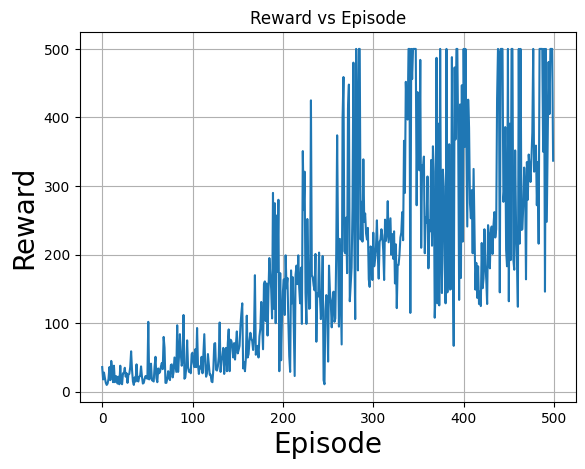

In [45]:
plt.plot(train_rewards, label='Rewards')
plt.xlabel('Episode', fontsize=20)
plt.ylabel('Reward', fontsize=20)
plt.title('Reward vs Episode')
plt.grid()